In [7]:
# Import All Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [8]:
# Import Data
data = pd.read_csv("./Corona_NLP.csv", encoding='ISO-8859-1')
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
# Check Data Type
data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)

In [10]:
# Check Data Null
print("Data Empty:", data.isnull().sum().sum())

Data Empty: 8590


In [11]:
# Drop Data Null
data.dropna(inplace=True)
print("Data Empty:", data.isnull().sum().sum())

Data Empty: 0


In [12]:
# Drop column
data.drop(columns=['UserName', 'ScreenName', 
                   'Location', 'TweetAt'], inplace=True)

In [13]:
# Simplify Data
data['Sentiment'] = data['Sentiment'].map({
    "Neutral": "Neutral",
    "Positive": "Positive",
    "Negative": "Negative",
    "Extremely Positive": "Positive",
    "Extremely Negative": "Negative"
})
sentiment = pd.get_dummies(data['Sentiment'])
df = pd.concat([data, sentiment], axis=1)
df.drop(columns='Sentiment', inplace=True)

In [14]:
# Data Cleaning with regex
def data_cleaner(tweet):
    # hapus link
    tweet = re.sub(r'http\S+', ' ', tweet)
    # hapus html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # hapus angka
    tweet = re.sub(r'\d+',' ', tweet)
    # hapus hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # hapus tag
    tweet = re.sub(r'@\w+',' ', tweet)
    # hapus kata tambahan
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

nltk.download('stopwords')
stop_words = stopwords.words('english')
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: x.lower()).apply(data_cleaner)
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Hafidh
[nltk_data]     Soekma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,OriginalTweet,Negative,Neutral,Positive
0,,0,1,0
1,advice talk neighbours family exchange phone n...,0,0,1
2,coronavirus australia: woolworths give elderly...,0,0,1
5,news regionâs first confirmed covid- case cam...,0,0,1
6,cashier grocery store sharing insights prove c...,0,0,1


In [15]:
# Split Data
tweet = df['OriginalTweet'].values
sentiment = df[['Negative', 'Neutral', 'Positive']].values
tweet_train, tweet_test, sentiment_train, sentiment_test = train_test_split(
    tweet, sentiment, test_size=0.2, random_state=69
)

In [16]:
# Tokenizer Data
tokenizer = Tokenizer(num_words=36000, oov_token='-')
tokenizer.fit_on_texts(tweet_train)
tokenizer.fit_on_texts(tweet_test)

sequens_train = tokenizer.texts_to_sequences(tweet_train)
sequens_test = tokenizer.texts_to_sequences(tweet_test)

padded_train = pad_sequences(sequens_train, padding='post')
padded_test = pad_sequences(sequens_test, padding='post')

In [17]:
# Create Model NN
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=36000, output_dim=16),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [18]:
# Create Callback
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.9:
            print("\nValidasi Akurasi telah mencapai > 90%!")
            self.model.stop_training = True

callback0 = Callback()
callback1 = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

In [19]:
# Train Model
history = model.fit(
    padded_train,
    sentiment_train,
    validation_data=(padded_test, sentiment_test),
    epochs=5,
    callbacks=[callback0, callback1],
)

Epoch 1/5
815/815 [==============================] - ETA: 0s - loss: 0.9786 - accuracy: 0.4789

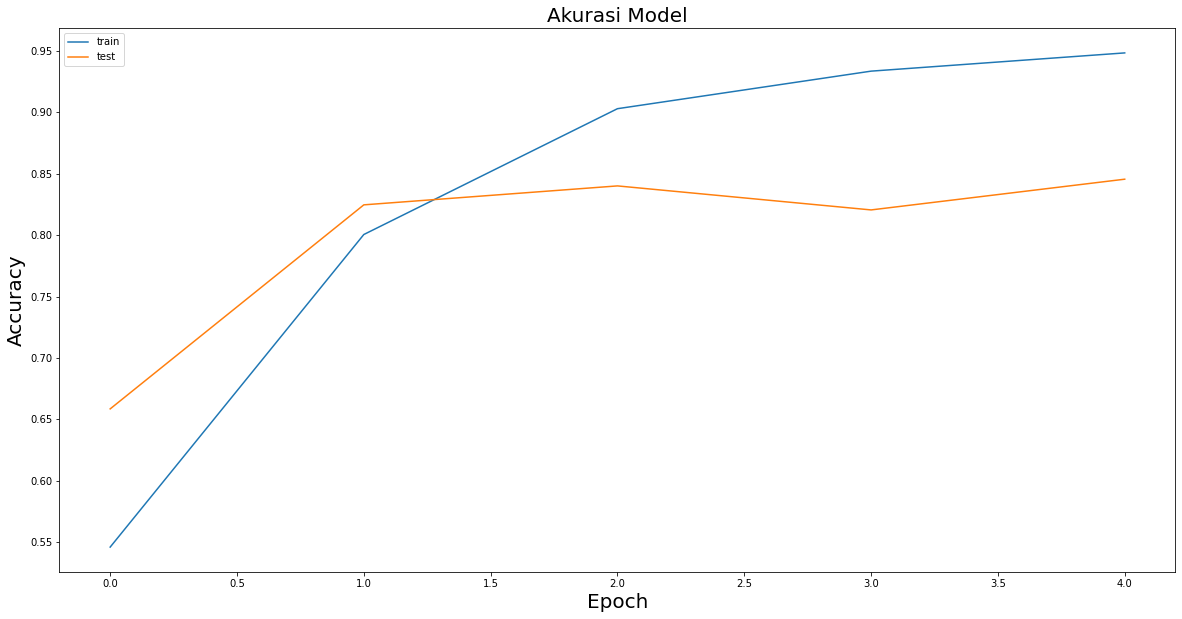

In [ ]:
# Plot Accuracy Model
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

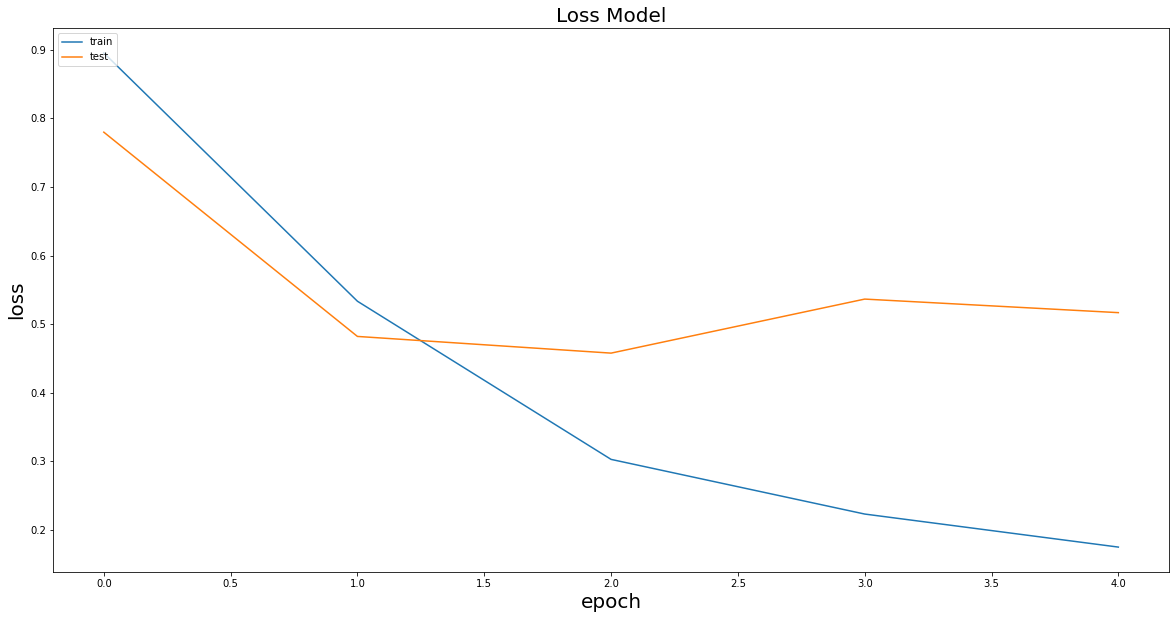

In [ ]:
# Plot Loss Model
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()